In [12]:
## Apply decision tree classifier to bank customer churn prediction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, ensemble
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance
import pickle
from utils import confusion_matrix_plot, make_gridsearchcv_results

datapath = '../data/'

# Read in bank customer churning data
file = 'Churn_Modelling.csv'
df_original = pd.read_csv(datapath + file)
df_original.head()

# Check class balance
df_original['Exited'].value_counts()

# Calculate average balance of customers who churned
avg_churned_bal = df_original[df_original['Exited']==1]['Balance'].mean()
avg_churned_bal

# Create a new df that drops RowNumber, CustomerId, Surname, and Gender cols
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], axis=1)
churn_df.head()

# Dummy encode categorical variables
churn_df = pd.get_dummies(churn_df, drop_first=True)
churn_df.head()

# Define the y (target) variable
y = churn_df['Exited']

# Define the X (predictor) variables
X = churn_df.copy()
X = X.drop('Exited', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


Accuracy: 0.790
Precision: 0.486
Recall: 0.503
F1 Score: 0.494


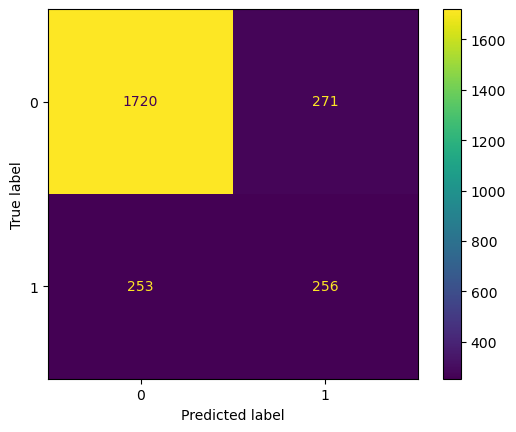

DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=0)


C:\Users\hychy\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [13]:
# Instantiate the decision tree model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

# Generate performance metrics
print("Accuracy:", "%.3f" % metrics.accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % metrics.precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % metrics.recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % metrics.f1_score(y_test, dt_pred))

# Generate and plot confusion matrix
confusion_matrix_plot(decision_tree, X_test, y_test)

# Plot the tree
#plt.figure(figsize=(15,12))
#plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns, 
#          class_names={0:'stayed', 1:'churned'}, filled=True);
#plt.show()

# Now start tuning decision tree
cv_params = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50],
             'min_samples_leaf': [2,3,4,5,6,7,8,9,10,15,20,50]}
scoring = ['accuracy', 'precision', 'recall', 'f1']
dectr_grid = GridSearchCV(estimator=decision_tree, param_grid=cv_params, scoring=scoring, cv=5, n_jobs=-1, refit='f1')
dectr_grid.fit(X_train, y_train)
print(dectr_grid.best_estimator_)
dectr_grid.best_score_

res_tab_tr = make_gridsearchcv_results("decision_tree", dectr_grid)

# Plot the best tree
#plt.figure(figsize=(15,12))
#plot_tree(dectr_grid.best_estimator_, max_depth=2, fontsize=14, feature_names=X.columns, 
#          class_names={0:'exited', 1:'stayed'}, filled=True);
#plt.show()

In [14]:
## Now use random forest:

# further split training data into validation and training data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# tested set of parameters
cv_params = {'n_estimators' : [50,100,150,200,250,500], 
              'max_depth' : [10,20,50],        
              'min_samples_leaf' : [0.5,0.75,1], 
              'min_samples_split' : [0.001, 0.01],
              'max_features' : ["sqrt"], 
              'max_samples' : [.5,.7,.9]}

split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

# Build the model
rf = RandomForestClassifier(random_state=0)
rf_grid = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=custom_split, refit='f1', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_estimator_)
rf_grid.best_score_

res_tab_rf = make_gridsearchcv_results("rf", rf_grid)

Fitting 1 folds for each of 324 candidates, totalling 324 fits
RandomForestClassifier(max_depth=20, max_samples=0.7, min_samples_split=0.001,
                       n_estimators=200, random_state=0)


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=75, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)
0.5843437953759352


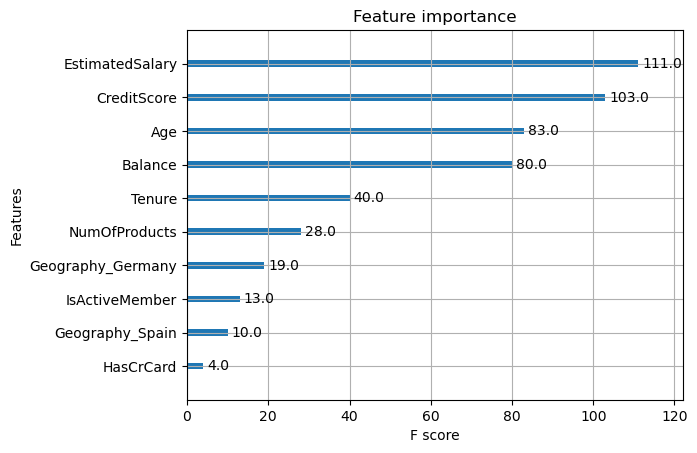

In [15]:
## Now use gradient boost
xgb = XGBClassifier(random_state=0)
# Define parameters
cv_params = {'max_depth': [3,4,5,6,7,8],
    'min_child_weight': [1,2,3,4,5],
    'learning_rate': [0.1,0.2,0.3,0.4,0.5],
    'n_estimators': [50,75,100,125],
    'subsample': [0.7],
    'colsample_bytree': [0.7]}

scoring = ['accuracy', 'precision', 'recall', 'f1']
xgb_grid = GridSearchCV(estimator=xgb, param_grid=cv_params, scoring=scoring, cv=5, refit='f1', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_estimator_)
print(xgb_grid.best_score_)

plot_importance(xgb_grid.best_estimator_)

res_tab_xgb = make_gridsearchcv_results("xgb", xgb_grid)

In [ ]:
## Now use adaboost
adb = AdaBoostClassifier(estimator=rf_grid.best_estimator_, random_state=0)
cv_params = {'n_estimators': [10,20,50,100,200],
             'learning_rate': [0.02,0.1,0.5,1.0,2.0],
             'algorithm': ['SAMME']}
adb_grid = GridSearchCV(estimator=adb, param_grid=cv_params, scoring=scoring, cv=5, refit='f1', n_jobs=-1, verbose=1)
adb_grid.fit(X_train, y_train)

print(adb_grid.best_estimator_)
print(adb_grid.best_score_)

res_tab_adb = make_gridsearchcv_results("adb", adb_grid)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
## Now combine all results into one table:
res_tab = pd.concat([res_tab_tr, res_tab_rf, res_tab_xgb, res_tab_adb], ignore_index=True, axis=0)
res_tab.to_csv('decTree_bankCustomerChurn_results.csv')